
# 🕵️ Titanic — Exploratory Data Analysis (EDA)

**Purpose:** Explore patterns related to survival to guide feature engineering and modeling.  
We will move from simple distributions → relationships with the target → interactions.



## 0) Setup
We import common libraries, set plotting/display options, and load the same raw CSVs used in the Data Overview.  
All plots are for **understanding** — we do **not** change the original data here.


In [1]:

# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Settings for nicer tables/plots
sns.set(style="whitegrid", context="notebook")
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Load data (adjust path if needed)
DATA_DIR = "data"
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))

print("train.shape:", train.shape)
print("test.shape :", test.shape)

# Sanity check: target distribution
train['Survived'].value_counts(normalize=True).rename('proportion').to_frame()


train.shape: (891, 12)
test.shape : (418, 11)


,proportion
Survived,
0,0.616162
1,0.383838



## 0.1) Small helper utilities
We define tiny helpers to:
- quickly plot value counts for a categorical column
- compute a survival rate table for categories (mean of `Survived` grouped by that column)


In [2]:

def plot_value_counts(df, col, title=None, rotation=0):
    vc = df[col].value_counts(dropna=False)
    sns.barplot(x=vc.index, y=vc.values, palette="Set2")
    plt.title(title if title else f"Value counts: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=rotation)
    plt.show()

def survival_rate_by(df, col):
    # Returns a DataFrame with survival rate by category for a given column
    tab = df.groupby(col)['Survived'].mean().sort_values(ascending=False).to_frame('survival_rate')
    return tab



## 1) Univariate Analysis — Categorical
We look at each categorical variable's distribution to understand imbalance and possible feature usefulness.
- `Sex`
- `Pclass` (ticket class; can be treated as categorical)
- `Embarked` (port of embarkation)
- `Cabin` (we'll extract **Deck** as the first letter for EDA only)


/tmp/ipykernel_30110/3463840315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette="Set2")


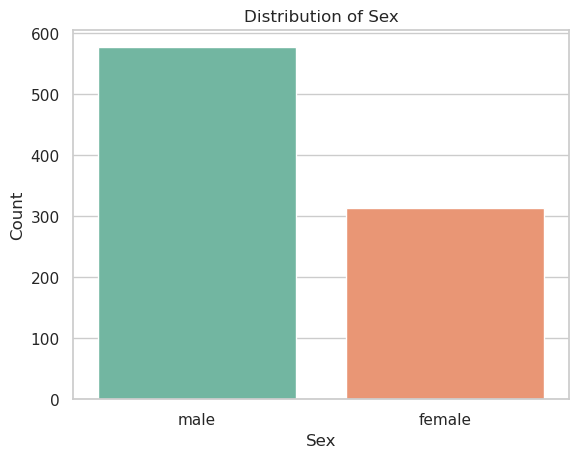

/tmp/ipykernel_30110/3463840315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette="Set2")


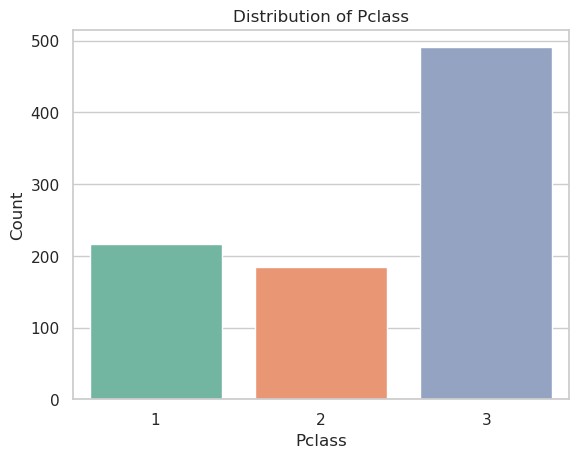

/tmp/ipykernel_30110/3463840315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette="Set2")


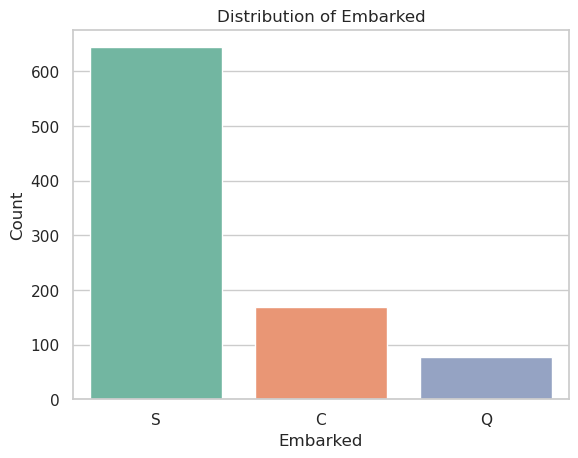

/tmp/ipykernel_30110/3463840315.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.index, y=vc.values, palette="Set2")


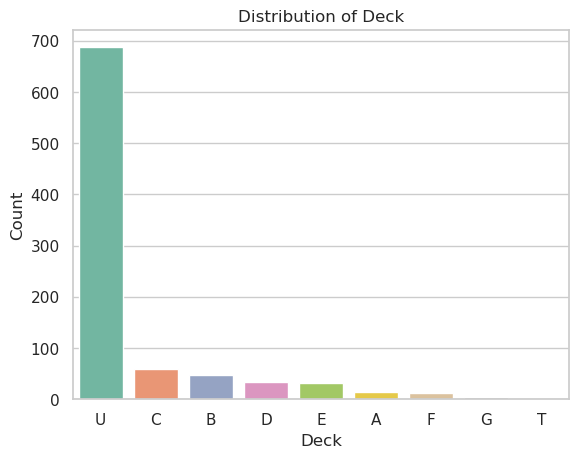

In [4]:

# Extract Deck from Cabin for EDA (first letter). Many values missing → label as 'U' (Unknown).
train['Deck'] = train['Cabin'].astype(str).str[0]
train.loc[train['Deck'] == 'n', 'Deck'] = 'U'  # 'nan' -> 'U' (Unknown)

# Plot categorical distributions
for col in ['Sex', 'Pclass', 'Embarked', 'Deck']:
    if col in train.columns:
        plot_value_counts(train, col, title=f"Distribution of {col}")



## 1.2) Univariate Analysis — Numerical
We inspect distributions to detect skew/outliers and to anticipate transformations/imputation strategies.
- `Age` (missing values common)
- `Fare` (often right-skewed; might benefit from log transform later)
- `SibSp`, `Parch` (family relations onboard)


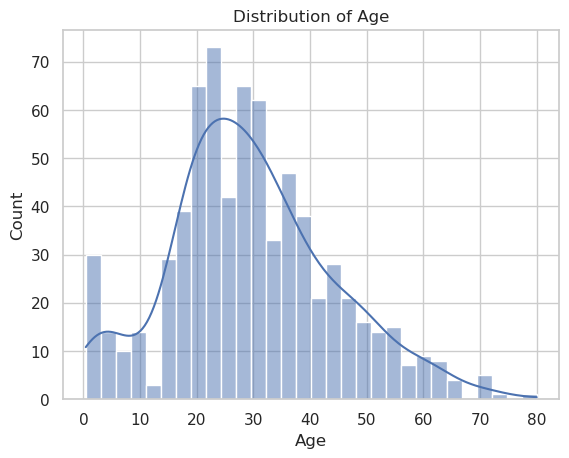

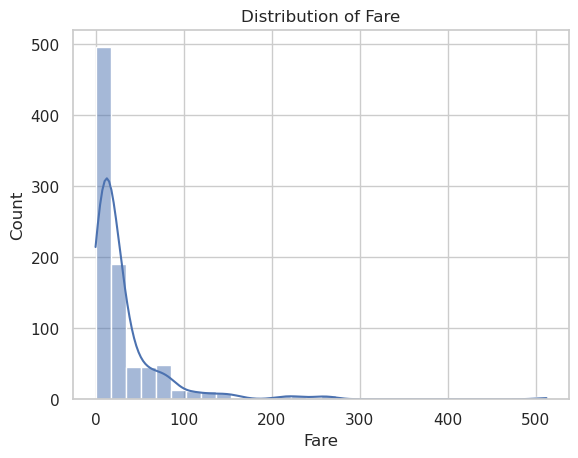

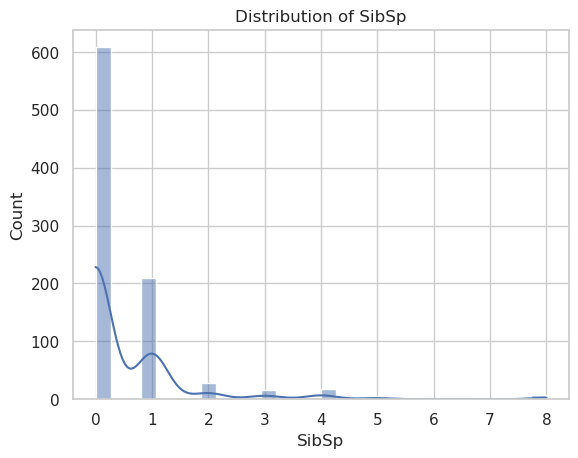

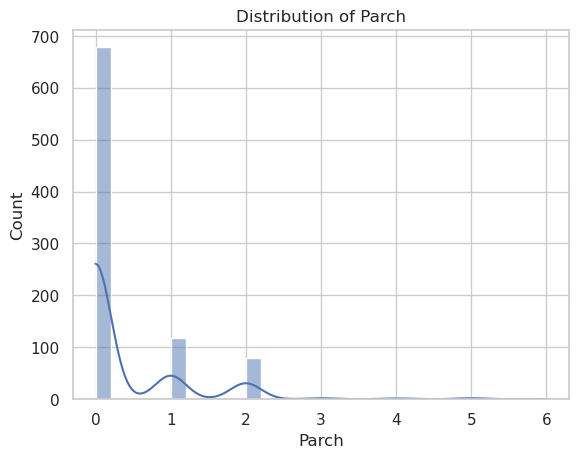

Fare skew: 4.787316519674893


In [5]:

numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
for col in numeric_cols:
    if col in train.columns:
        s = train[col].dropna()
        sns.histplot(s, bins=30, kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

# Quick note on skew of Fare (useful later)
if 'Fare' in train.columns:
    print("Fare skew:", train['Fare'].dropna().skew())



## 1.3) Missingness Overview
Understanding missing data guides imputation choices. We show a simple bar chart of missing counts.


/tmp/ipykernel_30110/1795807647.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="muted")


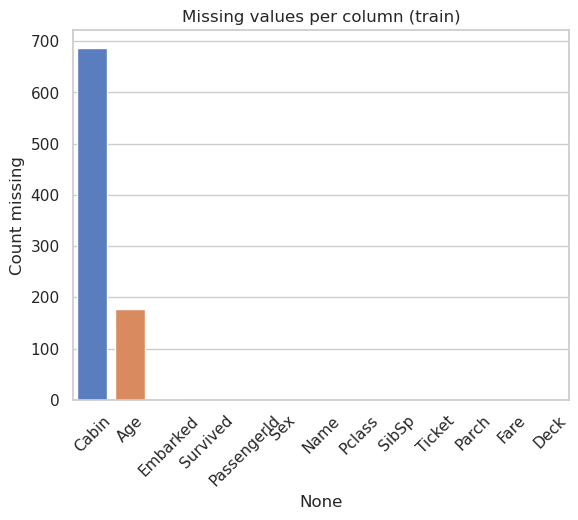

In [6]:

missing_counts = train.isnull().sum().sort_values(ascending=False)
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette="muted")
plt.title("Missing values per column (train)")
plt.ylabel("Count missing")
plt.xticks(rotation=45)
plt.show()



## 2) Bivariate Analysis — Categorical vs Survival
We want to see **how survival depends on each category**.
We compute survival rates by group (mean of `Survived` per category).


,survival_rate
Sex,
female,0.742038
male,0.188908


/tmp/ipykernel_30110/1823225705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


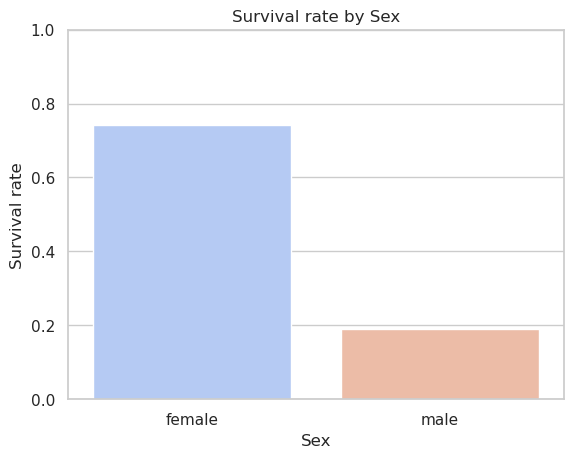

,survival_rate
Pclass,
1,0.629630
2,0.472826
3,0.242363


/tmp/ipykernel_30110/1823225705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


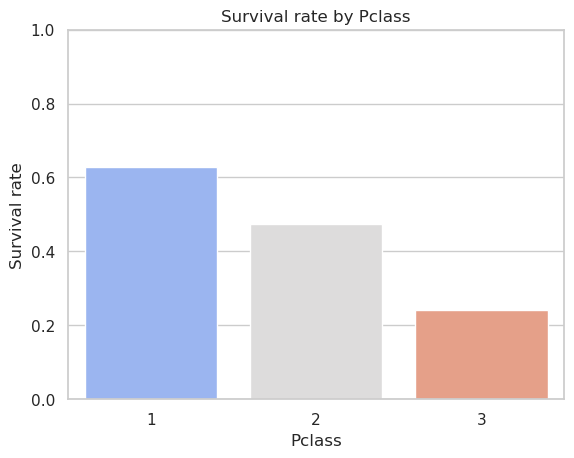

,survival_rate
Embarked,
C,0.553571
Q,0.389610
S,0.336957


/tmp/ipykernel_30110/1823225705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


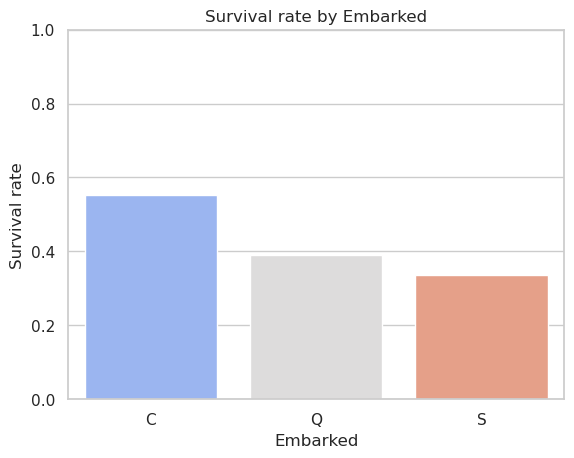

,survival_rate
Deck,
D,0.757576
E,0.750000
B,0.744681
F,0.615385
C,0.593220
G,0.500000
A,0.466667
U,0.299854
T,0.000000


/tmp/ipykernel_30110/1823225705.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


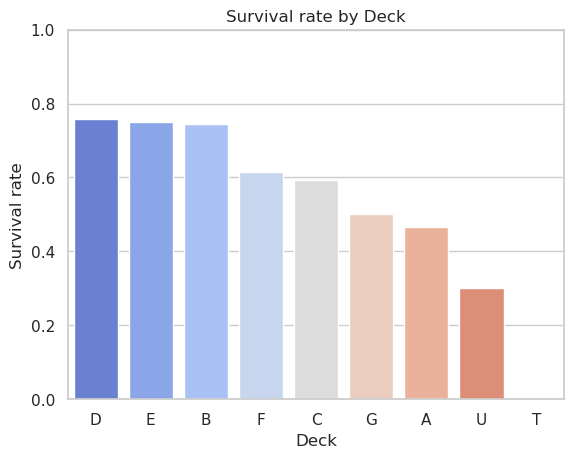

In [8]:

for col in ['Sex', 'Pclass', 'Embarked', 'Deck']:
    if col in train.columns:
        tab = survival_rate_by(train, col)
        display(tab)
        sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")
        plt.title(f"Survival rate by {col}")
        plt.ylabel("Survival rate")
        plt.ylim(0, 1)
        plt.show()



## 2.2) Bivariate Analysis — Numerical vs Survival
We compare distributions of numeric features **by survival outcome** using seaborn boxplots.  
This avoids deprecation warnings and provides clearer visuals.


/tmp/ipykernel_30110/570751977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Survived", y=col, data=train, palette="Set2")


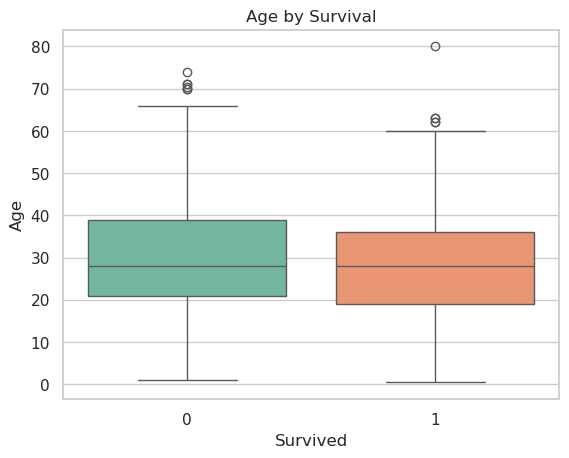

/tmp/ipykernel_30110/570751977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Survived", y=col, data=train, palette="Set2")


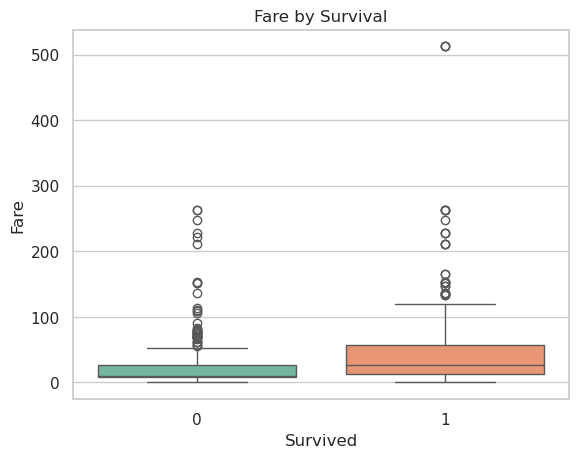

/tmp/ipykernel_30110/570751977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Survived", y=col, data=train, palette="Set2")


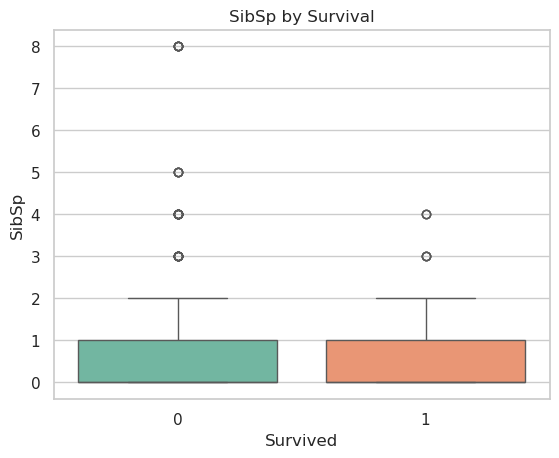

/tmp/ipykernel_30110/570751977.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Survived", y=col, data=train, palette="Set2")


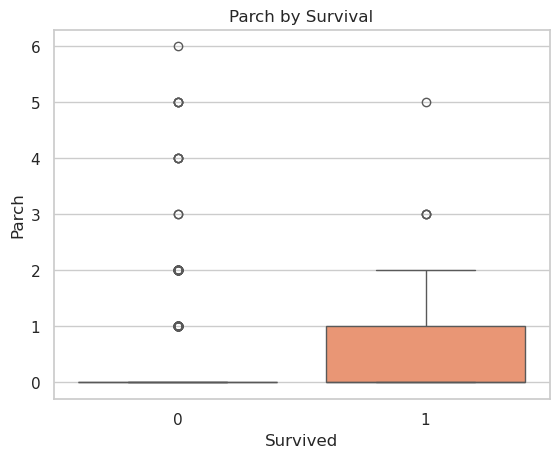

In [7]:

for col in ['Age', 'Fare', 'SibSp', 'Parch']:
    if col in train.columns:
        sns.boxplot(x="Survived", y=col, data=train, palette="Set2")
        plt.title(f"{col} by Survival")
        plt.show()



## 2.3) Family-related features (EDA-only)
It's common to derive **FamilySize** and **IsAlone** from `SibSp` and `Parch`.  
We'll compute them here **for exploration** and check survival rates.


,FamilySize,IsAlone
count,891.000000,891.000000
mean,1.904602,0.602694
std,1.613459,0.489615
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,11.000000,1.000000


/tmp/ipykernel_30110/1418192772.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = df.groupby(col)['Survived'].mean().to_frame('survival_rate')


,survival_rate
FamilyBucket,
1,0.303538
2,0.552795
3-4,0.610687
5+,0.161290


/tmp/ipykernel_30110/1418192772.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


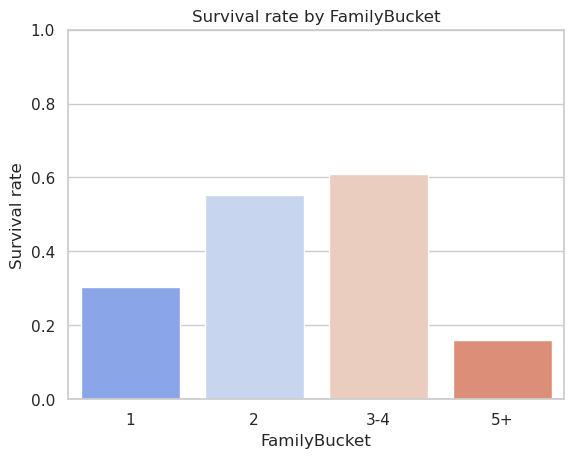

,survival_rate
IsAlone,
0,0.505650
1,0.303538


/tmp/ipykernel_30110/1418192772.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


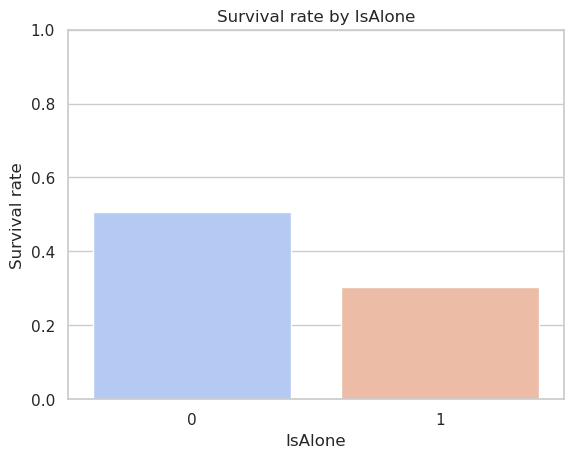

In [9]:

df = train.copy()
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

display(df[['FamilySize', 'IsAlone']].describe())

# Survival rate by FamilySize bucketed
df['FamilyBucket'] = pd.cut(df['FamilySize'], bins=[0,1,2,4,11], labels=['1','2','3-4','5+'], include_lowest=True)
for col in ['FamilyBucket', 'IsAlone']:
    tab = df.groupby(col)['Survived'].mean().to_frame('survival_rate')
    display(tab)
    sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")
    plt.title(f"Survival rate by {col}")
    plt.ylabel("Survival rate")
    plt.ylim(0,1)
    plt.show()



## 2.4) Title extraction (from Name) — EDA
Passenger titles carry signal (e.g., **Mr**, **Mrs**, **Miss**, **Master**, **Dr**).  
We'll extract a simplified `Title` and check survival rates.


,survival_rate
Title,
Mrs,0.792000
Miss,0.697802
Master,0.575000
Other,0.444444
Mr,0.156673


/tmp/ipykernel_30110/196824551.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")


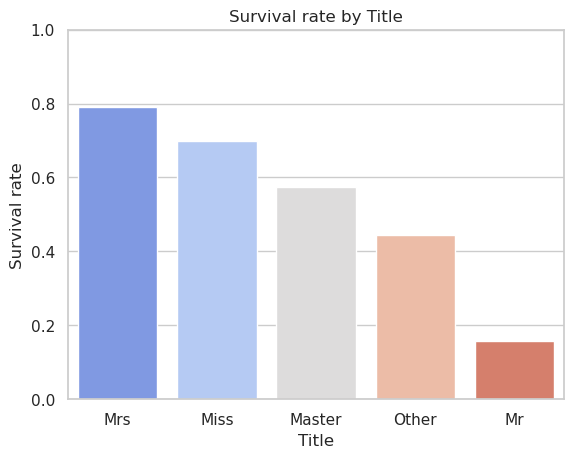

In [10]:

df = train.copy()

# Extract title between ', ' and '.' e.g., "Smith, Mr. John" -> "Mr"
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()

# Map rare titles to 'Other'
common_titles = ['Mr','Mrs','Miss','Master']
df['Title'] = df['Title'].apply(lambda t: t if t in common_titles else 'Other')

tab = df.groupby('Title')['Survived'].mean().sort_values(ascending=False).to_frame('survival_rate')
display(tab)

sns.barplot(x=tab.index, y=tab['survival_rate'], palette="coolwarm")
plt.title("Survival rate by Title")
plt.ylabel("Survival rate")
plt.ylim(0,1)
plt.show()



## 3) Multivariate Interactions
We explore **interactions** between key variables.  
A simple way is a heatmap for survival by two categorical features.


Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


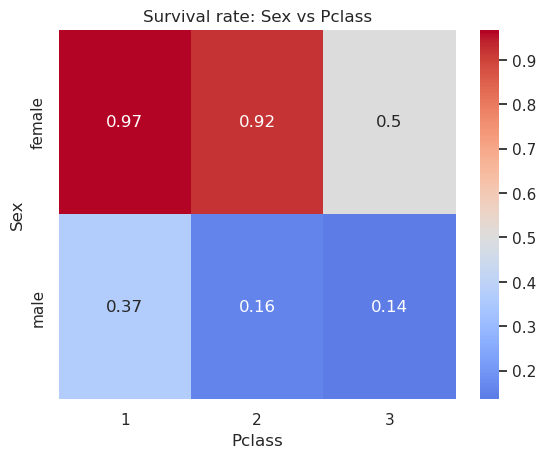

In [11]:

pivot = train.pivot_table(values='Survived', index='Sex', columns='Pclass', aggfunc='mean')
display(pivot)

sns.heatmap(pivot, annot=True, cmap="coolwarm", center=0.5)
plt.title("Survival rate: Sex vs Pclass")
plt.show()



## 4) Correlation Analysis (numeric)
We compute Pearson correlations among numeric variables (including the target).  
This is a rough guide → categorical effects are better captured in the earlier analyses.


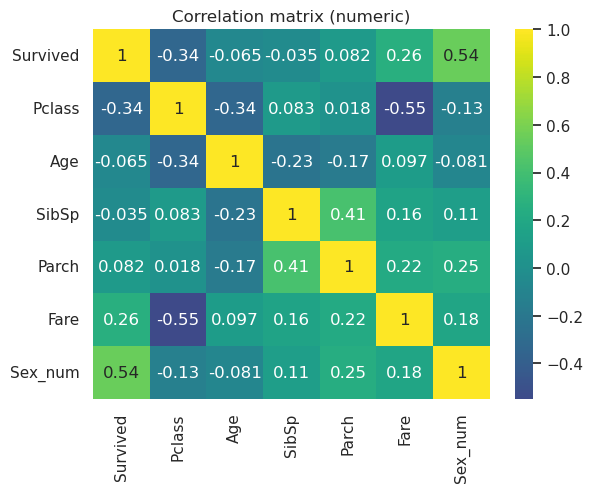

In [12]:

df = train.copy()

# Encode Sex for correlation
if 'Sex' in df.columns:
    df['Sex_num'] = (df['Sex'] == 'female').astype(int)

# Simple median imputation for numeric columns (just for correlation calc)
for col in ['Age', 'Fare']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

num_cols = [c for c in ['Survived','Pclass','Age','SibSp','Parch','Fare','Sex_num'] if c in df.columns]
corr = df[num_cols].corr()

sns.heatmap(corr, annot=True, cmap="viridis", center=0)
plt.title("Correlation matrix (numeric)")
plt.show()


## Key Findings (EDA Summary)

**Dataset overview**
- Training set: **891** passengers.
- Overall survival rate: **38.38%**.

**Single-feature patterns**
- **Sex** is highly discriminative: survival was **74.20%** for females vs **18.89%** for males.
- **Pclass** shows a strong socio-economic gradient: 1st class **62.96%**, 2nd **47.28%**, 3rd **24.24%**.
- **Embarked** also carries signal: Cherbourg (C) **55.36%**, Queenstown (Q) **38.96%**, Southampton (S) **33.70%**.

**Numeric variables**
- **Age** (median [IQR]) by outcome: Died **28.0** [21.0, 39.0] vs Survived **28.0** [19.0, 36.0].  
  Medians are similar; I expect non-linear effects (e.g., higher survival among young children).
- **Fare** (median [IQR]) by outcome: Died **10.50** [7.85, 26.00] vs Survived **26.00** [12.48, 57.00].  
  Higher fares correlate with higher survival; the distribution is right-skewed, so a log transform will likely help.

**Family structure (engineered for EDA)**
- **FamilySize** relates to survival: alone (**30.35%**), size 2 (**55.28%**), size 3–4 (**61.07%**), size 5+ (**16.13%**).  
  Small families fare better than solo travelers or very large families. I will keep **FamilySize** and **IsAlone**.

**Title from Name (engineered for EDA)**
- Survival by simplified title: **Mrs 79.20%**, **Miss 69.78%**, **Master 57.50%**, **Other 44.44%**, **Mr 15.67%**.  
  Titles encode age/status and are strongly predictive; I will include a simplified **Title** feature.

**Cabin / Deck**
- `Cabin` is missing for **77.10%** of rows. Among known values, deck survival rates are high for D (**75.76%**), E (**75.00%**), B (**74.47%**), etc.; Unknown (U) is **29.99%**.  
  I will extract **Deck** (first letter) and assign missing as **U** to retain information without dropping rows.

**Missing data to address**
- **Cabin ~77.1%**, **Age ~19.87%**, **Embarked ~0.22%**.  
  I will impute `Embarked` with the mode, impute `Age` using grouped medians (e.g., by **Title × Pclass × Sex**), and derive **Deck** from `Cabin` with a dedicated “Unknown” category.

**Modeling implications**
- A minimal model with **Sex + Pclass** should outperform trivial baselines.
- Adding **log(Fare)**, **Embarked**, **FamilySize/IsAlone**, and **Title** should improve performance further.
- **Age** likely requires non-linear handling (bins or tree-based models).
- **Deck** adds signal when available; representing missing as **U** avoids discarding data.
